In [34]:
using PyCall
using PyPlot
using ForwardDiff, Flux
using LinearAlgebra
using Distributions
import StatsBase
cmd = pyimport("cmdtools")

PyObject <module 'cmdtools' from '/home/axsk/cmdtools/src/cmdtools/__init__.py'>

In [35]:
N = 13

sys = cmd.systems.diffusion.DoubleWell(nx=N,beta=3, xlims=(-1.5,1.5))
Q = sys.Q.todense()
K = exp(Q*.5)

13×13 Array{Float64,2}:
 0.0526103    0.573021     0.326155     …  2.49444e-11  1.37704e-13
 0.013635     0.501216     0.408379        1.0095e-10   5.93551e-13
 0.00300378   0.15806      0.626987        1.24408e-9   7.93133e-12
 0.000731879  0.0482647    0.331448        2.88367e-8   2.01228e-10
 0.000161469  0.0126916    0.12371         7.97826e-7   6.13584e-9
 2.60507e-5   0.00237923   0.0302867    …  1.83401e-5   1.56663e-7
 2.6215e-6    0.000273146  0.00431456      0.000273146  2.6215e-6
 1.56663e-7   1.83401e-5   0.000346519     0.00237923   2.60507e-5
 6.13584e-9   7.97826e-7   1.75808e-5      0.0126916    0.000161469
 2.01228e-10  2.88367e-8   7.28882e-7      0.0482647    0.000731879
 7.93133e-12  1.24408e-9   3.55801e-8   …  0.15806      0.00300378
 5.93551e-13  1.0095e-10   3.21432e-9      0.501216     0.013635
 1.37704e-13  2.49444e-11  8.61195e-10     0.573021     0.0526103

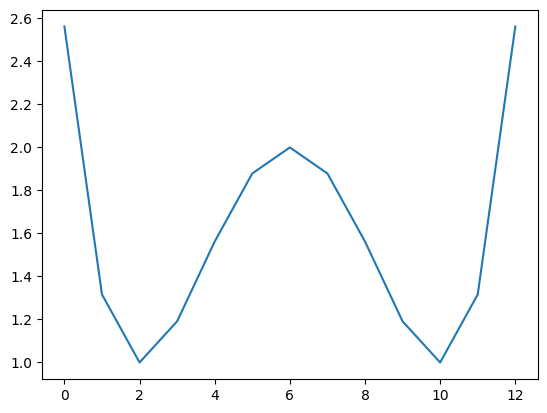

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f704e16cc40>

In [36]:
plot(sys.u')

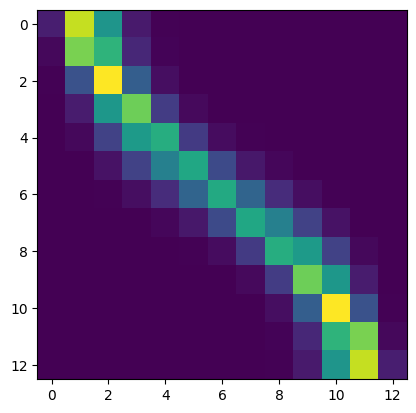

PyObject <matplotlib.image.AxesImage object at 0x7f704e21c520>

In [37]:
imshow(K)

In [38]:
bnd = fill(NaN,size(K,1))
bnd[1+1] = 0
bnd[end-1] = 1

bndinds = findall(!isnan, bnd)
bnd

13-element Array{Float64,1}:
 NaN
   0.0
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   1.0
 NaN

In [39]:
function committor(K, b)
    A = copy(K)
    b = copy(b)
    for i in 1:length(b)
        if isnan(b[i])
            b[i] = 0
            A[i,i] -= 1
        else
            A[i,:].=0
            A[i,i]=1
        end
    end
    A\b
end

c = committor(K,bnd)

13-element Array{Float64,1}:
 0.01581438175296682
 0.0
 0.036884515255810546
 0.057081688970651585
 0.10515422503417002
 0.2400288788780668
 0.49999999999999917
 0.7599711211219315
 0.8948457749658282
 0.9429183110293469
 0.9631154847441882
 1.0
 0.9841856182470324

In [40]:
sample(x) = rand(Categorical(K[x,:]))

random_data(nx, ny) = let xs = [rand(1:N) for i in 1:nx]
    [(x, [sample(x) for i in 1:ny]) for x in xs]
end

linear_data(ny) = [(x, [sample(x) for i in 1:ny]) for x in 1:N]

data = linear_data(100)

13-element Array{Tuple{Int64,Array{Int64,1}},1}:
 (1, [3, 3, 2, 3, 2, 3, 3, 2, 3, 2  …  2, 2, 2, 2, 3, 3, 3, 3, 2, 3])
 (2, [2, 2, 2, 2, 3, 3, 3, 3, 3, 3  …  3, 3, 2, 3, 2, 3, 3, 3, 4, 2])
 (3, [3, 4, 2, 3, 3, 3, 3, 4, 2, 3  …  2, 3, 3, 3, 3, 3, 3, 3, 3, 3])
 (4, [3, 3, 3, 3, 4, 4, 3, 4, 4, 4  …  4, 4, 4, 2, 4, 2, 4, 4, 3, 4])
 (5, [5, 5, 5, 5, 4, 5, 4, 6, 3, 4  …  2, 5, 3, 5, 4, 3, 4, 5, 5, 5])
 (6, [6, 4, 6, 4, 5, 5, 6, 6, 4, 9  …  8, 5, 7, 6, 5, 5, 7, 7, 5, 6])
 (7, [7, 6, 9, 7, 8, 7, 7, 8, 8, 6  …  6, 7, 6, 5, 9, 4, 6, 6, 9, 8])
 (8, [8, 9, 8, 9, 8, 6, 8, 9, 9, 10  …  6, 8, 9, 8, 8, 7, 10, 10, 9, 3])
 (9, [10, 9, 9, 9, 9, 10, 9, 9, 10, 10  …  9, 10, 10, 9, 10, 10, 10, 11, 8, 8])
 (10, [10, 10, 9, 10, 10, 10, 11, 10, 11, 9  …  11, 11, 10, 10, 11, 9, 12, 12, 10, 11])
 (11, [10, 11, 12, 12, 11, 11, 11, 10, 11, 11  …  11, 11, 11, 11, 11, 12, 11, 11, 11, 11])
 (12, [11, 12, 12, 11, 12, 11, 12, 12, 11, 11  …  11, 11, 11, 11, 11, 12, 11, 12, 11, 11])
 (13, [12, 11, 12, 12, 13, 13, 12, 11,

In [41]:
loss(c, x, ys) = 
    if x in bndinds
        0
    else
        abs(mean(c(y) for y in ys) - c(x))
    end

loss_batch(c, batch) = mean(loss(c,d...) for d in batch)

loss_batch (generic function with 1 method)

In [42]:
struct VectorModel
    c::Vector{Float64}
    bnd::Vector{Float64}
    bndinds::Vector{Int}
end

function (m::VectorModel)(x)::Float64
    if x in m.bndinds
        m.bnd[x]
    else
        m.c[x]
    end
end

Flux.trainable(m::VectorModel) = (m.c,)

model1 = VectorModel(rand(N), bnd, bndinds)
model1(5)

0.5714677623055562

In [43]:
struct NNModel
    nn
    bnd::Vector{Float64}
    bndinds::Vector{Int}
end

function (m::NNModel)(x)::Float32
    if x in m.bndinds
        m.bnd[Int(x)]
    else
        v = m.nn([x])::Vector{Float32}
        v[1] # we work with scalars, nn with arrays
    end
end

Flux.trainable(m::NNModel) = (m.nn, )

model2 = NNModel(Chain(Dense(1,10), Dense(10,1)), bnd, bndinds)
model2(5.)

-3.7496872f0

In [44]:
error(x::Vector) = norm(x - c) / sqrt(length(x))
error(f) = error([f(x) for x in 1:N])

error (generic function with 2 methods)

In [45]:
function learn(model, nx=100, ny=100)
    errors = []
    losses = []

    opt = ADAM(0.1)

    data_batch = [linear_data(ny) for i in 1:nx]

    @time for d in data_batch
        ps = Flux.params(model)
        l, pb = Flux.pullback(ps) do
            loss_batch(model, d)
        end
        grad = pb(1)
        Flux.Optimise.update!(opt, ps, grad)
        push!(errors, error(model))
        push!(losses, l)
    end
    @show losses[end], errors[end]
    model, losses, errors
end

#model, losses, errors = learn(VectorModel(rand(N), bnd, bndinds), 200, 5)
model, losses, errors = learn(NNModel(Chain(Dense(1,10,sigmoid), Dense(10,10,sigmoid), Dense(10,1,sigmoid)), bnd, bndinds))



  4.307490 seconds (5.84 M allocations: 244.743 MiB, 1.54% gc time)
(losses[end], errors[end]) = (0.01957444127967227, 0.13245165879948856)
 27.577290 seconds (52.18 M allocations: 2.397 GiB, 2.97% gc time)
(losses[end], errors[end]) = (0.015161996f0, 0.03916032340060026)


(NNModel(Chain(Dense(1, 10, σ), Dense(10, 10, σ), Dense(10, 1, σ)), [NaN, 0.0, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 1.0, NaN], [2, 12]), Any[0.060490295f0, 0.056965325f0, 0.054479342f0, 0.05628926f0, 0.047087695f0, 0.03989693f0, 0.026582481f0, 0.026012372f0, 0.025845397f0, 0.023333307f0  …  0.007523775f0, 0.012230698f0, 0.006529281f0, 0.00401178f0, 0.0048392694f0, 0.004540948f0, 0.0067362357f0, 0.008619254f0, 0.0038794144f0, 0.015161996f0], Any[0.408545239392421, 0.3743587080040265, 0.333677585825173, 0.3112400501811557, 0.31000083870833495, 0.3165147730888138, 0.34466948669603503, 0.4094278989992402, 0.47675497486205803, 0.48736938164576915  …  0.07651683032201849, 0.03615758684863514, 0.005646709733257605, 0.02551508671931758, 0.007960043259965223, 0.007961818165434675, 0.03043921123095188, 0.015325484383736614, 0.04582235718885987, 0.03916032340060026])

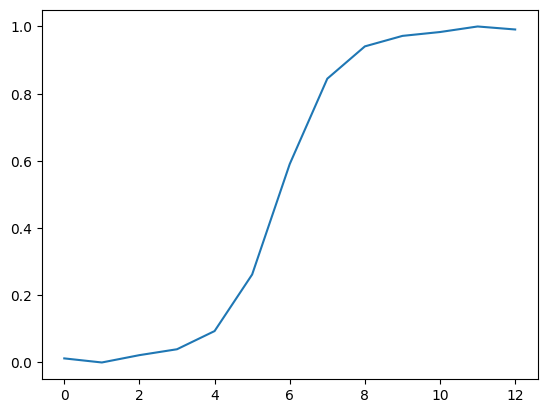

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f703dce33a0>

In [46]:
plot(model.(1:13))

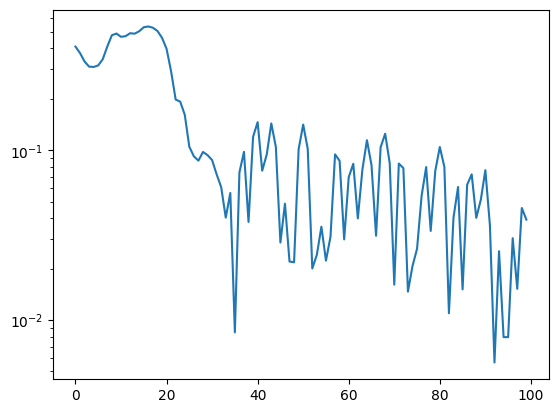

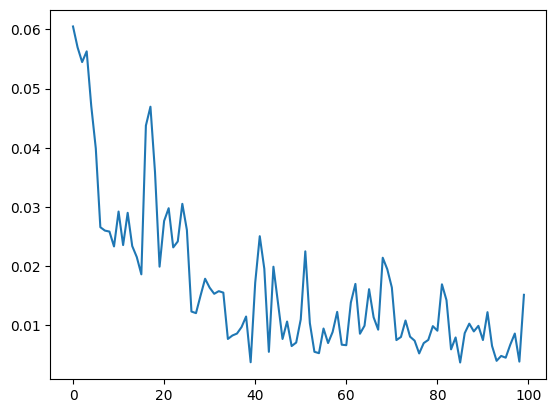

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f703dc72b50>

In [47]:
PyPlot.plot(errors)
PyPlot.yscale(:log)
figure()
plot(losses)
#yscale(:log)

In [48]:
chat = [model(x) for x in 1:N]

hcat(chat, c)

13×2 Array{Float64,2}:
 0.0121408  0.0158144
 0.0        0.0
 0.0218233  0.0368845
 0.0393667  0.0570817
 0.0934606  0.105154
 0.261857   0.240029
 0.590494   0.5
 0.844609   0.759971
 0.940766   0.894846
 0.971981   0.942918
 0.983494   0.963115
 1.0        1.0
 0.991048   0.984186

In [49]:
loss_batch(model, linear_data(100000))

0.0059220125f0

In [50]:
truth = VectorModel(c, bnd, bndinds)
loss_batch(truth, linear_data(100000))

0.00020092573063621317

In [51]:
logspace(start, stop, n) = exp.(LinRange(log(start), log(stop), n))

logspace (generic function with 1 method)

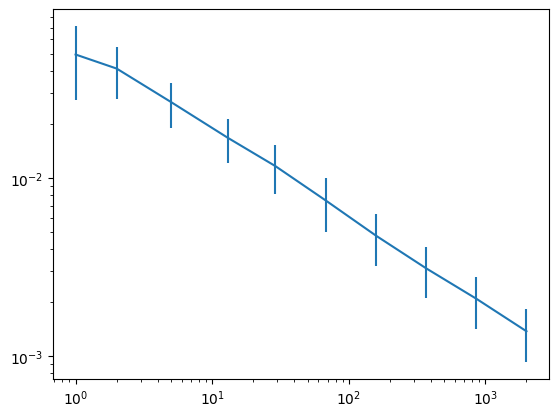

In [52]:
nys = round.(Int, logspace(1, 2000, 10))
means = []
stds  = []
repeats = 100

for ny in nys
    m,s = StatsBase.mean_and_std(loss_batch(truth, linear_data(ny)) for i in 1:repeats)
    push!(means, m)
    push!(stds, s)
end

errorbar(nys, means, yerr = stds)
xscale(:log)
yscale(:log)